#### Last Modified: August 15th, 2022 (Opal). 

## sOpInf on MHD (MAS Code) Solar Wind Radial Speed Dataset


In [1]:
import os
curr_dir = os.getcwd()
os.chdir("../")
print("current directory path = ", os.getcwd())

current directory path =  /Users/oissan/PycharmProjects/Space-Weather-ROM-Revised


In [2]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
from scipy.integrate import solve_ivp
from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.model.variable import Variable
import rom_operator_inference as roi
from MHD.notebook_functions import *
from scipy import stats
from hux_code.numerical_methods import apply_numerical_method
from hux_code.hux_propagation import apply_hux_f_model
import time
import astropy.units as u

In [3]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 18}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 

### Import MHD solar wind velocity results.

In [4]:
# mas output - br, rho, vr
cr = "2210"
mas_path = get_mas_path(cr=cr)
model = MASOutput(mas_path)
print(model.variables)

['bp', 'br', 'bt', 'p', 'rho', 't', 'vp', 'vr', 'vt']


In [5]:
# read in MHD velocity results. 
vr_model = model['vr']

In [6]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2pi)
p = vr_model.phi_coords
t = vr_model.theta_coords
# 30 solar radii to approximately 1 AU
# 1 solar radii = 695,700 km
r = (vr_model.r_coords * u.solRad).to(u.km)
# velocity profile 
f = vr_model.data
print(f.shape)

(128, 111, 140)


In [7]:
np.max(r[1:] - r[:-1]) - np.min(r[1:] - r[:-1])

<Quantity 10.61553955 km>

In [8]:
np.max(t[1:] - t[:-1]) - np.min(t[1:] - t[:-1])

2.384185791015625e-07

In [9]:
omega_rot = (2 * np.pi) / (25.38 * 86400)

In [10]:
# force periodicity on f
# since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p = np.append(p, 2*np.pi) 

# append the first slice p=0 to velocity matrix. 
f = np.append(f,[f[0,:, :]],axis=0)

In [11]:
V = np.array(f[:, 55, :])

In [12]:
V_HUX = apply_hux_f_model(f[:, 55, 0], (r[1:]-r[:-1]).to(u.km).value, p[1:] -p[:-1]).T

In [13]:
V_HUX.shape

(129, 140)

### Background: Solar Wind

Due to the high temperature of the Sun's upper atmosphere, called the corona, particles are able to escape the Sun's gravity, resulting in the Solar Wind. The solar wind is a stream of charged particles mostly consists of electrons, protons and alpha particles. The solar wind varies in density, temperature and speed over time and over solar latitude and longitude.

Here we will model the radial velocity of the Solar Wind protons denoted by $v_{r}$. As the solar wind propagates out in the heliosphere it can reach velocities of around 300-700 km/sec. 

In [14]:
def plot_heat_data(Z, title, sample_columns=np.append(np.arange(0, len(r), 20),len(r) -1), variable="v", xlabel="$\phi$ (Deg.)", 
                  save_fig=False, file_name=None):
    fig, ax = plt.subplots(figsize=(14, 4))
    color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

    for j in sample_columns:
        x_all = np.concatenate([[0], Z[:,j], [0]])  # Pad results with boundary conditions.
        ax.plot(p*(180/np.pi), Z[:,j], color=next(color), label=str(variable) + rf"$(\phi,r$" + "=" + 
                str(round(r[j].to(u.AU).value,2)) + " AU)")

    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_xticks([0, 90, 180, 270, 360])
    ax.set_ylabel(variable + " (km/s)", fontsize=15)
    ax.legend(loc=(1.05, .05))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    fig.suptitle(title, fontsize=15)
    
    if save_fig:
        fig.savefig(file_name, dpi=500, bbox_inches='tight')

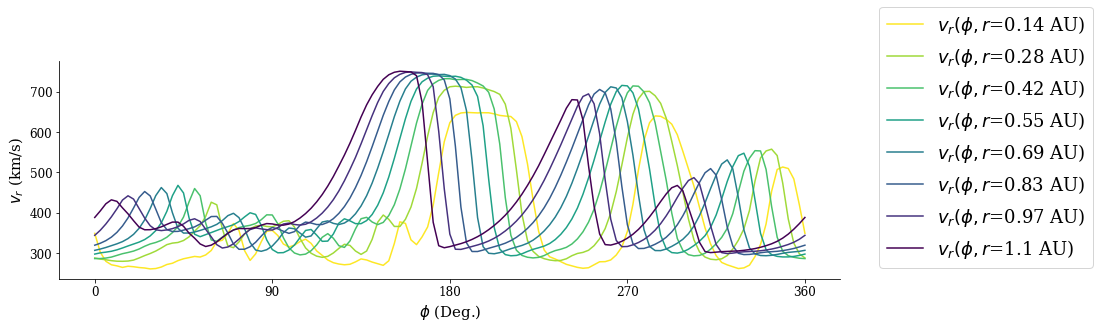

In [15]:
plot_heat_data(V, "", variable=r"$v_{r}$", save_fig=True, file_name="MHD/figs/CR"+ str(cr) +"/original_dataset_MHD.png")

In [16]:
def periodic_corr_np(x, y):
    """Periodic correlation, implemented using np.correlate.

    x and y must be real sequences with the same length.
    """
    return np.correlate(x, np.hstack((y[1:], y)), mode='valid')

def normalize(x):
    return (x - np.mean(x))/np.std(x)

In [17]:
v1 = V[:, 0]
shift_vec = [0]
for ii in range(1, len(r)):
    v2 = V[:, ii]
    corr = periodic_corr_np(normalize(v1), normalize(v2))
    corr = corr/np.max(corr)
    shift_vec.append(p[np.argmax(corr)]*180/np.pi)

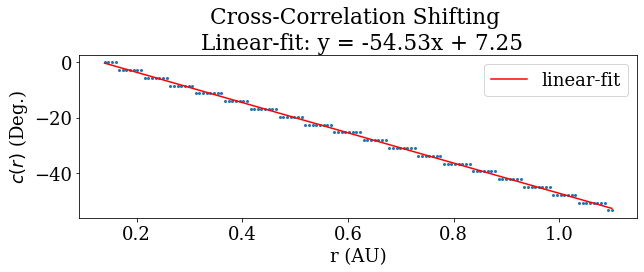

In [18]:
fig, ax = plt.subplots(figsize =(10, 3))
ax.scatter(r.to(u.AU), -np.array(shift_vec), s=4)

n = int(len(r)*0.7)
m, b = np.polyfit(r[:n].to(u.AU).value, -np.array(shift_vec[:n]), 1)
_ = ax.plot(r.to(u.AU), m*r.to(u.AU).value + b, c="r", label="linear-fit")
_ = ax.legend()
_ = ax.set_xlabel("r (AU)")
_ = ax.set_ylabel("$c(r)$ (Deg.)")
_ = ax.set_title("Cross-Correlation Shifting \n Linear-fit: y = " + str(round(m, 2)) + "x + " + str(round(b, 2)))

In [19]:
def shift_function(r, m, b):
    return m * r + b

In [20]:
V_new = np.zeros((len(p), len(r)))

V_new[:, 0] = V[:, 0]

for jj in range(1, len(r)):
    # interpolate on the current eulerian grid. 
    shift = shift_function(r[jj].to(u.AU).value, m=m, b=b)
    # interpolate over the shifted coordinate
    V_new[:, jj] = np.interp(p + shift*(np.pi/180), p, V[:, jj], period=2*np.pi)

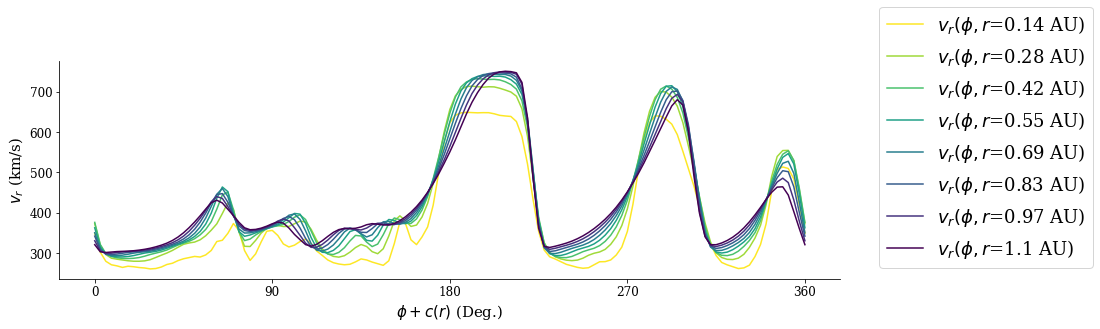

In [21]:
plot_heat_data(V_new, "", variable=r"$v_{r}$", xlabel=r"$\phi + c(r)$ (Deg.)", 
              save_fig=True, file_name="MHD/figs/CR"+ str(cr) +"/shifted_dataset_MHD.png")

### Split Training and Testing datasets. 

* Training = First $l$ radial indexes.
* Testing/Validation = Remaining $n_{r}-l$ radial indexes.

In [22]:
# set up the first l indexes used for training. 
l = int(0.7*(len(r)))

In [23]:
X= V_new

In [24]:
X_train = V_new[:, :l]
X_test = V_new[:, l:]

In [25]:
r_train = r[:l]
r_test = r[l:]

In [26]:
print("X train shape", np.shape(X_train))
print("Radial distance train: " + str(r[0].to(u.AU)) + " to " + str(r[l].to(u.AU)))
print("\nX test shape", np.shape(X_test))
print("Radial distance test: " + str(r[l].to(u.AU)) + " to " + str(r[-1].to(u.AU)))

X train shape (129, 98)
Radial distance train: 0.13951401782886472 AU to 0.816444039517221 AU

X test shape (129, 42)
Radial distance test: 0.816444039517221 AU to 1.0996495197497314 AU


### Intrusive vs. non-intrustive ROM
* intrusive- ROM operators requires access to the discretized FOM operators.

* nonintrustive -learns ROMs from simulation data without direct access to the FOM operators. 

## Using the ROM Operator Inference Package

### Choosing the Reduced-model Dimension
There are several ways to choose $r$ in an informed way.
A simple choice is to look at the singular values $\{\sigma_j\}_{j=1}^{n}$ of the snapshot matrix $X$ and select the number of $\sigma_{j}$ that are greater than a given threshold.
This also gives us a sense of whether or not we expect model reduction to be successful: if the singular values do not decay quickly, then we will need many modes to capture the behavior of the system.

In [27]:
svdvals = la.svdvals(X_train)
svdvals_prev = la.svdvals(V[:, :l])

In [28]:
# Calculate the cumulative energy.
thresh = .996
cum_energy = np.cumsum(svdvals) / np.sum(svdvals)
cum_energy_prev = np.cumsum(svdvals_prev) / np.sum(svdvals_prev)

# Determine the points at which the cumulative energy passes the threshold.
rank = sum([rank < thresh for rank in cum_energy])
rank_prev = sum([rank < thresh for rank in cum_energy_prev])
print(f"r (Shifted coordinates)= {rank}")
print(f"r (Eularian coordinates)= {rank_prev}")

r (Shifted coordinates)= 9
r (Eularian coordinates)= 15


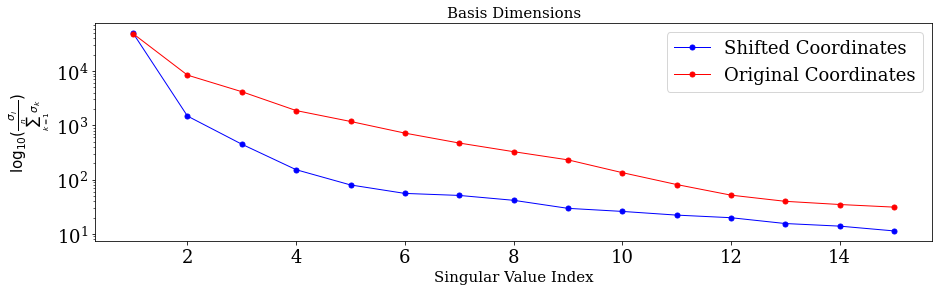

In [29]:
#Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(15, 4))
#plot singluar values cumulative energy
ax.plot(np.arange(1, 16), svdvals[:15], '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted Coordinates")
ax.plot(np.arange(1, 16), svdvals_prev[:15], '.-', ms=10, lw=1, zorder=3, c="r", label="Original Coordinates")
ax.set_yscale("log")

plt.legend()
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax.set_ylabel(r"$\log_{10}(\frac{\sigma_{i}}{\sum_{k=1}^{n} \sigma_{k}})$", fontsize=15)
_ = ax.set_title("Basis Dimensions", fontsize=15)

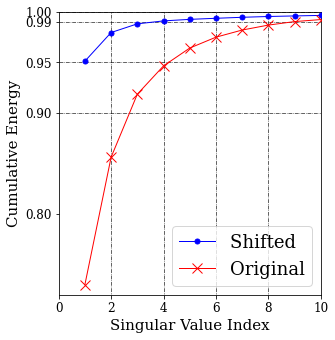

In [30]:
# Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(5, 5))

xlim= 10

# plot singluar values cumulative energy
ax.plot(np.arange(1, svdvals.size + 1), cum_energy, '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted ")
ax.plot(np.arange(1, svdvals.size + 1), cum_energy_prev, 'x-', ms=10, lw=1, zorder=3, c="r", label="Original")
# get current y-limits 
ylim = ax.get_ylim()

# set up axis. 
ax.hlines(0.9, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(0.95, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(0.99, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(1, 0, xlim, color="black", linewidth=.6, linestyle="-.")


ax.vlines(2, 0, 1, color="black", linewidth=.6, linestyle="-.")
ax.vlines(4, 0, 1, color="black", linewidth=.6, linestyle="-.")
ax.vlines(6, 0, 1, color="black", linewidth=.6, linestyle="-.")
ax.vlines(8, 0, 1, color="black", linewidth=.6, linestyle="-.")

plt.legend()
_ = ax.set_ylim(ylim)
_ = ax.set_xlim(0, xlim)
_ = ax.set_yticks(ticks=[0.8, 0.9, 0.95, 0.99, 1])
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax.set_ylabel(r"Cumulative Energy", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()     
ax.set_ylim(0.72, 1)
plt.savefig("MHD/figs/CR2210/singular_value_decay_MAS_equator.png", pad_inches=1)

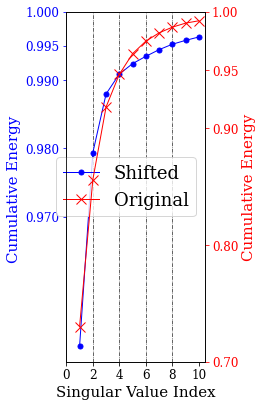

In [31]:
# Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(4, 6))

xlim= 10

ax.plot(np.arange(1, xlim + 1), cum_energy[:xlim], '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted")
ax.plot(np.arange(1, xlim + 1)*np.nan, cum_energy_prev[:xlim]*np.nan, 'x-', ms=10, lw=1, zorder=3, c="r", label="Original")
ax2=ax.twinx()
ax2.plot(np.arange(1, xlim + 1), cum_energy_prev[:xlim], 'x-', ms=10, lw=1, zorder=3, c="r")
_ = ax2.set_ylabel("Cumulative Energy", c="r", fontsize=15)
_ = ax.legend()
_ = ax2.set_yticks(ticks=[0.7, 0.8, 0.9, 0.95,  1])
_ = ax.set_yticks(ticks=[ 0.97, 0.98, 0.99, 0.995, 1])
_ = ax.set_ylim(top= 1)
_ = ax2.set_ylim(top=1)
_ = ax.tick_params(axis='y', colors='blue')
_ = ax2.tick_params(axis='y', colors='red')
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax.set_ylabel(r"Cumulative Energy ", c="b", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
_ = ax2.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks([0, 2, 4, 6, 8,10])
ax.axvline(2, color="black", linewidth=.6, linestyle="-.")
ax.axvline(4,  color="black", linewidth=.6, linestyle="-.")
ax.axvline(6, color="black", linewidth=.6, linestyle="-.")
ax.axvline(8, color="black", linewidth=.6, linestyle="-.")
plt.tight_layout()

plt.savefig("MHD/figs/singular_value_decay.png", pad_inches=1, dpi=700)

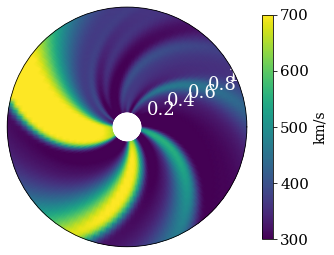

In [32]:
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': 'polar'})

ax.set_rlim(0)
ax.set_thetalim(0, 2 * np.pi)
ax.set_xticks([])
ax.set_ylim(0,1.1)
rlabels = ax.get_ymajorticklabels()
for label in rlabels:
    label.set_color('white')

pos = ax.pcolormesh(p, r.to(u.AU).value, V.T, vmin=300, vmax=700, shading='gouraud', cmap="viridis")

cbar = fig.colorbar(pos, ax=(ax), orientation="vertical", shrink=0.7)
cbar.ax.set_ylabel(r'km/s', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=15)

plt.tight_layout()
plt.savefig("MHD/figs/MAS_polar_original.png", dpi=600)

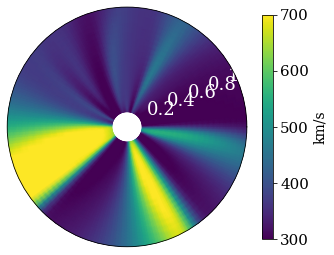

In [33]:
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': 'polar'})

ax.set_rlim(0)
ax.set_thetalim(0, 2 * np.pi)
ax.set_xticks([])
ax.set_ylim(0,1.1)
rlabels = ax.get_ymajorticklabels()
for label in rlabels:
    label.set_color('white')

pos = ax.pcolormesh(p, r.to(u.AU).value, V_new.T, vmin=300, vmax=700, shading='gouraud', cmap="viridis")

cbar = fig.colorbar(pos, ax=(ax), orientation="vertical", shrink=0.7)
cbar.ax.set_ylabel(r'km/s', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=15)

plt.tight_layout()
plt.savefig("MHD/figs/MAS_polar_shifted.png", dpi=600)

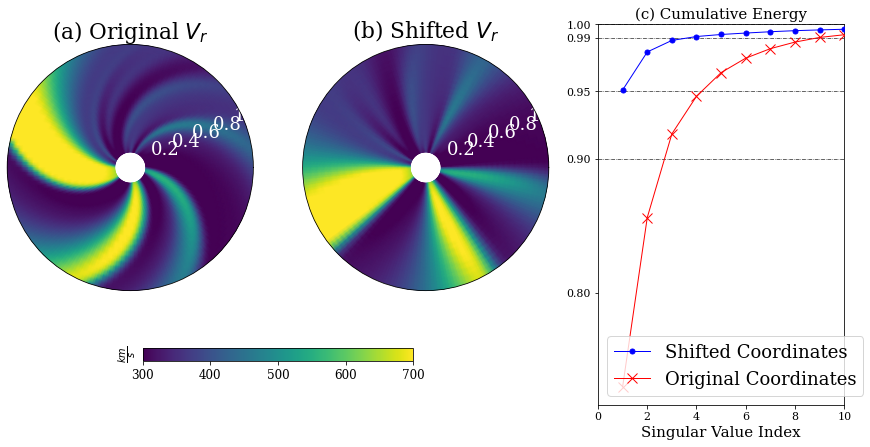

In [34]:
fig=plt.figure(figsize=(15, 7))
ax = fig.add_subplot(131, polar=True)
ax.set_rlim(0)
ax.set_thetalim(0, 2 * np.pi)
ax.set_xticks([])
ax.set_ylim(0,1.1)
rlabels = ax.get_ymajorticklabels()
for label in rlabels:
    label.set_color('white')

pos = ax.pcolormesh(p, r.to(u.AU).value, V.T, vmin=300, vmax=700, shading='gouraud', cmap="viridis")
ax.set_title("(a) Original $V_{r}$")
ax1 = fig.add_subplot(132, polar=True)
ax1.set_rlim(0)
ax1.set_thetalim(0, 2 * np.pi)
ax1.set_xticks([])

ax1.set_ylim(0,1.1)
rlabels = ax1.get_ymajorticklabels()
for label in rlabels:
    label.set_color('white')

pos = ax1.pcolormesh(p, r.to(u.AU).value, V_new.T, vmin=300, vmax=700, shading='gouraud', cmap="viridis")

cbar = fig.colorbar(pos, ax=(ax1, ax), orientation="horizontal", shrink=0.5)
cbar.ax.set_ylabel(r'$\frac{km}{s}$', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=12)
_ = ax1.set_title("(b) Shifted $V_{r}$")

ax = fig.add_subplot(133)

xlim= 10

# plot singluar values cumulative energy
ax.plot(np.arange(1, svdvals.size + 1), cum_energy, '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted Coordinates")
ax.plot(np.arange(1, svdvals.size + 1), cum_energy_prev, 'x-', ms=10, lw=1, zorder=3, c="r", label="Original Coordinates")
# get current y-limits 
ax.set_ylim(top=1)
ylim = ax.get_ylim()

# set up axis. 
ax.hlines(0.9, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(0.95, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(0.99, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(1, 0, xlim, color="black", linewidth=.6, linestyle="-.")

plt.legend()
_ = ax.set_ylim(ylim)
_ = ax.set_xlim(0, xlim)
_ = ax.set_yticks(ticks=[0.8, 0.9, 0.95, 0.99, 1])
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
#_ = ax.set_ylabel(r"Cumulative Energy", fontsize=15)
_ = ax.set_title("(c) Cumulative Energy", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=11)


plt.savefig("MHD/figs/1D_MHD_shifted-comparison.png", dpi=600)

### Constructing a Low-dimensional Subspace
Next, we need a reduced basis $V_{r}$ to define the linear subspace to which the ROM states will be confined.
One of the most standard strategies, which aligns with our analysis of the singular values of $X$, is the _POD basis of rank $r$_ corresponding to $X$.
If $X$ has the singular value decomposition
$$
X = \Phi \Sigma \Psi^\mathsf{T},
$$
then the POD basis of rank $r$ consists of the first $r$ columns of $\Phi$:
$$
\Phi_{:,:r}.
$$

In [35]:
Vr, _ = roi.pre.pod_basis(X_train, rank, mode="dense")
print(f"Shape of Vr: {Vr.shape}")

Shape of Vr: (129, 9)


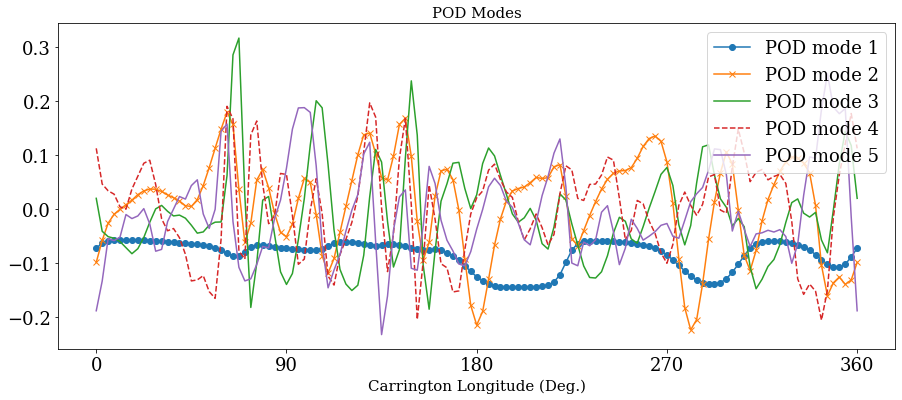

In [36]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot((180/np.pi) * p, Vr[:len(p),0], "-o", label=f"POD mode {1}")
ax.plot((180/np.pi) * p, Vr[:len(p),1], "-x", label=f"POD mode {2}")
ax.plot((180/np.pi) * p, Vr[:len(p),2], "-", label=f"POD mode {3}")
ax.plot((180/np.pi) * p, Vr[:len(p),3], "--", label=f"POD mode {4}")
ax.plot((180/np.pi) * p, Vr[:len(p),4], "-", label=f"POD mode {5}")


    
ax.set_xlabel("Carrington Longitude (Deg.)", fontsize=15)
ax.set_title("POD Modes", fontsize=15)
ax.set_xticks([0, 90, 180, 270, 360])
plt.legend(loc="upper right")
plt.show()

In [37]:
roi.pre.projection_error(X_train, Vr)

0.001044518842007726

### Quadratic ROM $\frac{d}{dr}\hat{\mathbf{v}}(r) = \hat{H}(\hat{\mathbf{v}}(r) \otimes \hat{\mathbf{v}}(r))$

In [38]:
# Calculate the cumulative energy.
thresh = .996

cum_energy = np.cumsum(svdvals) / np.sum(svdvals)

# Determine the points at which the cumulative energy passes the threshold.
rank = sum([rank < thresh for rank in cum_energy])
print(f"r = {rank}")

r = 9


In [39]:
Vr, _ = roi.pre.pod_basis(X_train, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot_nonuniform(X_train, r_train.value)            # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train, Xdot, P=1e5)                          # Construct the ROM with Operator Inference.
X_ROM = model.predict(X[:, 0], r.value, method="BDF") # Simulate the ROM.
V_ROM = convert_from_x_to_v(X_ROM, p, r, m, b, shift_function) # convert back to eulerian. 

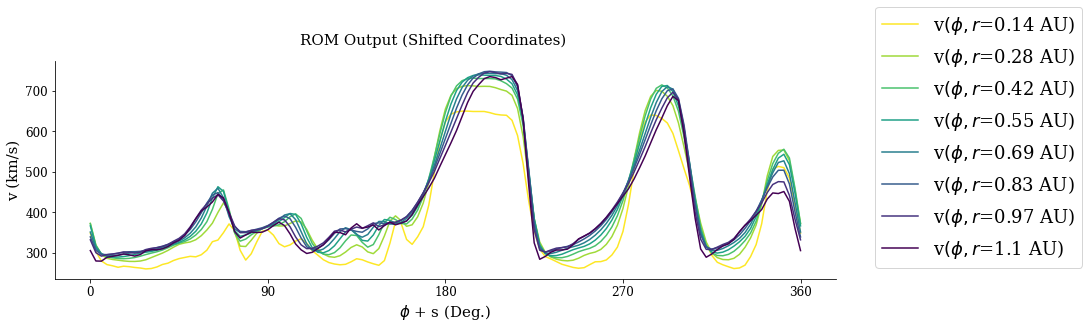

In [40]:
plot_heat_data(X_ROM, "ROM Output (Shifted Coordinates)", variable="v", xlabel="$\phi$ + s (Deg.)")

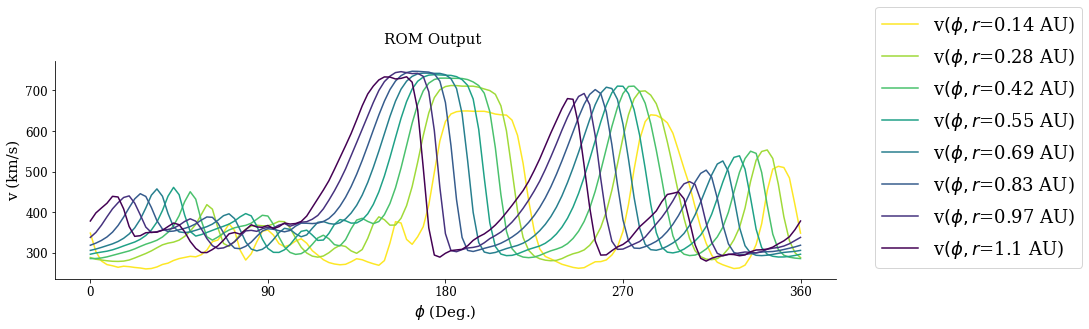

In [41]:
plot_heat_data(V_ROM, "ROM Output", variable="v")

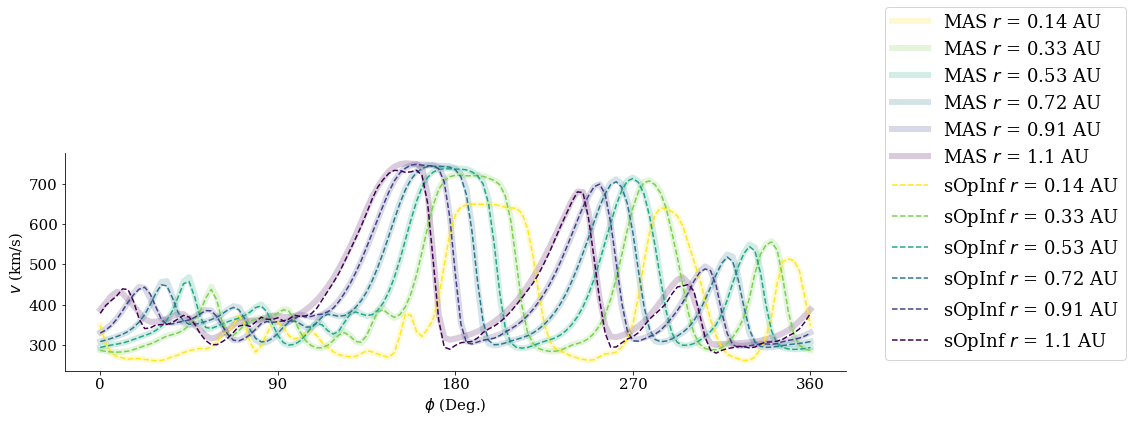

In [42]:
sample_columns = np.arange(0, len(r), int(len(r)//5))
sample_columns = np.append(sample_columns, len(r) -1)
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

for j in sample_columns:
    curr_color =next(color)
    ax.plot(p*(180/np.pi), V[:,j], color=curr_color, linewidth=6.0, alpha=0.2, label=r"MAS $r$ = "+
            str(round(r[j].to(u.AU).value,2)) + " AU")
    
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))
for j in sample_columns:
    curr_color =next(color)    
    ax.plot(p*(180/np.pi), V_ROM[:,j], "--", color=curr_color, label=rf"sOpInf $r$ = " + 
            str(round(r[j].to(u.AU).value,2)) + " AU")

ax.set_xlabel("$\phi$ (Deg.)", fontsize=15)
ax.set_xticks([0, 90, 180, 270, 360])
ax.set_ylabel("$v$ (km/s)", fontsize=15)
ax.legend(loc=(1.05, .05))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
#fig.suptitle("Shifted Operator Inference \n" + str(model), fontsize=14)
_ = ax.tick_params(axis='both', which='major', labelsize=15)

fig.savefig("MHD/figs/CR" + str(cr) + "/H/sopinf_vs_MAS_H.png", dpi=500, bbox_inches='tight')

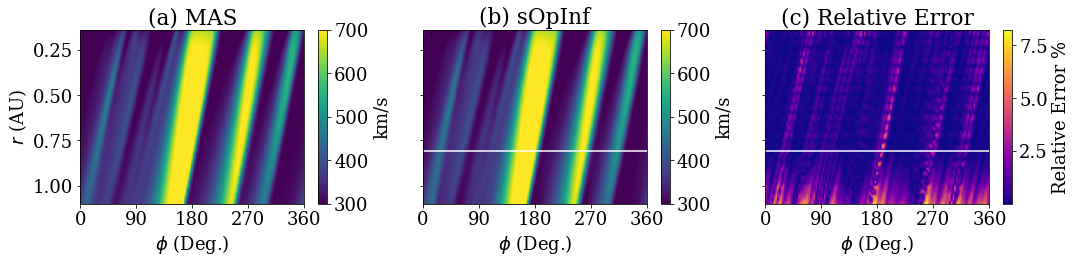

In [43]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 4))
pos = ax[0].imshow(V.T, extent=[0,360, r[-1].to(u.AU).value, 
                                r[0].to(u.AU).value], vmax=700, vmin=300, aspect="auto")
ax[0].set_xlabel(r"$\phi$ (Deg.)")
ax[0].set_ylabel(r"$r $ (AU)")
ax[0].set_title("(a) MAS")
ax[0].set_xticks([0, 90, 180, 270, 360])
cbar = fig.colorbar(pos, ax=ax[0])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[1].imshow(V_ROM.T, extent=[0,360, r[-1].to(u.AU).value, 
                                    r[0].to(u.AU).value], vmax=700, vmin=300, aspect="auto")
ax[1].set_xlabel(r"$\phi$ (Deg.)")
ax[1].set_title("(b) sOpInf")
ax[1].set_xticks([0, 90, 180, 270, 360])
ax[1].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[1])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[2].imshow(100*np.abs(V_ROM.T - V.T)/np.abs(V.T), extent=[0,360,r[-1].to(u.AU).value, r[0].to(u.AU).value], 
                   cmap="plasma", aspect="auto")
ax[2].set_xlabel(r"$\phi$ (Deg.)")
ax[2].set_xticks([0, 90, 180, 270, 360])
ax[2].set_title("(c) Relative Error")
ax[2].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[2])
cbar.ax.set_ylabel('Relative Error %', rotation=90)

plt.tight_layout()

fig.savefig("MHD/figs/CR" + str(cr) + "/H/sopinf_vs_MAS_H_2dprofile.png", dpi=500, bbox_inches='tight')

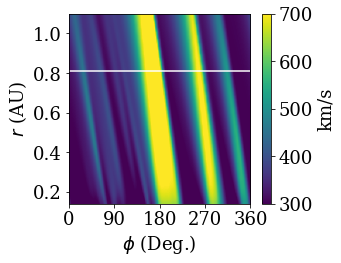

In [44]:
fig, ax = plt.subplots(figsize=(5, 4))

pos = ax.imshow(V.T, extent=[0,360, r[0].to(u.AU).value, r[-1].to(u.AU).value], vmax=700, vmin=300, aspect="auto", origin="lower")
ax.set_xlabel(r"$\phi$ (Deg.)")
ax.set_ylabel(r"$r $ (AU)")
ax.set_xticks([0, 90, 180, 270, 360])
cbar = fig.colorbar(pos, ax=ax)
cbar.ax.set_ylabel('km/s', rotation=90)
ax.plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
plt.tight_layout()

fig.savefig("MHD/figs/CR" + str(cr) + "/H/MAS_equator", dpi=500, bbox_inches='tight')

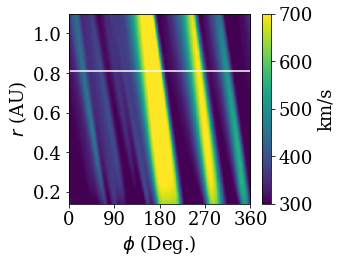

In [45]:
fig, ax = plt.subplots(figsize=(5, 4))

pos = ax.imshow(V_ROM.T, extent=[0,360, r[0].to(u.AU).value, 
                                r[-1].to(u.AU).value], vmax=700, vmin=300, aspect="auto", origin="lower")
ax.set_xlabel(r"$\phi$ (Deg.)")
ax.set_ylabel(r"$r $ (AU)")
ax.set_xticks([0, 90, 180, 270, 360])
cbar = fig.colorbar(pos, ax=ax)
cbar.ax.set_ylabel('km/s', rotation=90)
ax.plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
plt.tight_layout()

fig.savefig("MHD/figs/CR" + str(cr) + "/H/sOpInf_equator", dpi=500, bbox_inches='tight')

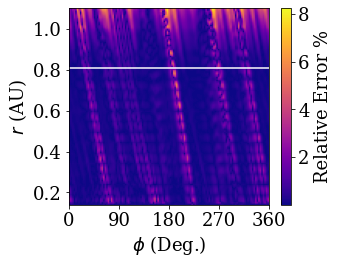

In [46]:
fig, ax = plt.subplots(figsize=(5, 4))

pos = ax.imshow(100*np.abs(V_ROM.T - V.T)/np.abs(V.T), extent=[0,360,r[0].to(u.AU).value, r[-1].to(u.AU).value], 
                   cmap="plasma", aspect="auto", origin="lower")
ax.set_xlabel(r"$\phi$ (Deg.)")
ax.set_ylabel(r"$r $ (AU)")
ax.set_xticks([0, 90, 180, 270, 360])
cbar = fig.colorbar(pos, ax=ax)
cbar.ax.set_ylabel('Relative Error %', rotation=90)
ax.plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
plt.tight_layout()

fig.savefig("MHD/figs/CR" + str(cr) + "/H/RE_equator", dpi=500, bbox_inches='tight')

In [47]:
print("Training RE (mean) %", 100*np.mean(np.abs(V[:, :l] - V_ROM[:, :l])/np.abs(V[:, :l])))
print("Training RE (median) %", 100*np.median(np.abs(V[:, :l] - V_ROM[:, :l])/np.abs(V[:, :l])))
print("Training RE (max) %", 100*np.max(np.abs(V[:, :l] - V_ROM[:, :l])/np.abs(V[:, :l])))

Training RE (mean) % 0.44921044536943955
Training RE (median) % 0.22953226907089322
Training RE (max) % 5.564148508141988


In [48]:
print("Testing RE (mean) %", 100*np.mean(np.abs(V[:, l:] - V_ROM[:, l:])/np.abs(V[:, l:])))
print("Testing RE (median) %", 100*np.median(np.abs(V[:, l:] - V_ROM[:, l:])/np.abs(V[:, l:])))
print("Testing RE (max) %", 100*np.max(np.abs(V[:, l:] - V_ROM[:, l:])/np.abs(V[:, l:])))

Testing RE (mean) % 1.2643511383623762
Testing RE (median) % 0.8497134933177285
Testing RE (max) % 8.235286985822063


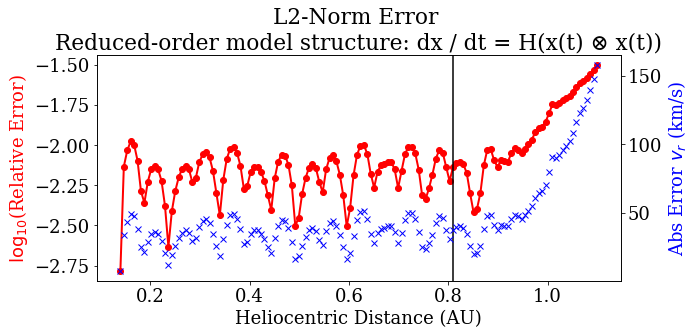

In [49]:
fig, ax = plt.subplots(figsize=(10, 5))
abs_l2errH, rel_l2errH = roi.post.lp_error(V, V_ROM)
_ = ax.plot(r.to(u.AU).value, np.log10(rel_l2errH),"-o", linewidth=2, c="r")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title("L2-Norm Error \n" + str(model))
_ = ax.set_ylabel("$\log_{10}$(Relative Error)", c="r")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

ax2=ax.twinx()
_ = ax2.plot(r.to(u.AU).value, abs_l2errH, "x", linewidth=2, c="b")
_ = ax2.set_ylabel("Abs Error $v_{r}$ (km/s)", c="b")

plt.tight_layout()

plt.savefig("MHD/figs/CR2210/H/L2_error_operator_inference_mhd_H.png", dpi=300)

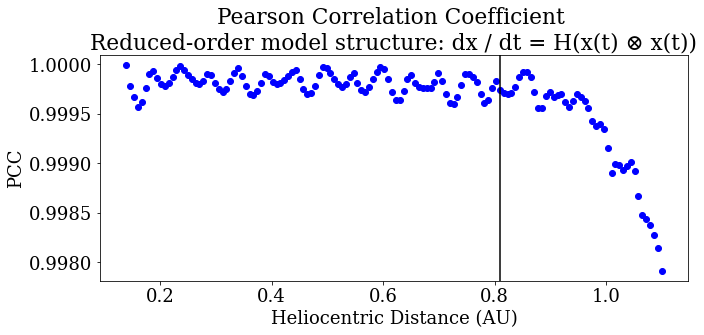

In [50]:
fig, ax = plt.subplots(figsize=(10, 5))
for jj in range(len(r)):
    pcc = stats.pearsonr(V[:, jj], V_ROM[:, jj])[0]
    ax.scatter(r.to(u.AU).value[jj], pcc, c="b")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_xlabel("Heliocentric Distance (AU)")
_ = ax.set_ylabel("PCC")
_ = ax.set_title("Pearson Correlation Coefficient \n" + str(model))

plt.tight_layout()
plt.savefig("MHD/figs/CR2210/H/pcc_shifted_operator_inference_mhd.png", dpi=300)

In [51]:
print("2d pcc = ", stats.pearsonr(np.ndarray.flatten(V), np.ndarray.flatten(V_ROM))[0])

print("2d pcc training = ", stats.pearsonr(np.ndarray.flatten(V[:, :l]), np.ndarray.flatten(V_ROM[:, :l]))[0])

print("2d pcc testing = ", stats.pearsonr(np.ndarray.flatten(V[:, l:]), np.ndarray.flatten(V_ROM[:, l:]))[0])

2d pcc =  0.999527648282982
2d pcc training =  0.9998066286053366
2d pcc testing =  0.9990025788750618


### Streamlines Comparison MHD vs. HUX vs. sOpInf

In [52]:
U_MHD = (V*u.km/u.second).to(u.AU/u.day).value
U_HUX = (V_HUX*u.km/u.second).to(u.AU/u.day).value
U_OpInf = (V_ROM*u.km/u.second).to(u.AU/u.day).value

phi_shift_mhd = compute_phi_shift_forward(p, r.to(u.AU).value, U_MHD)
phi_shift_hux = compute_phi_shift_forward(p, r.to(u.AU).value, U_HUX)
phi_shift_sopinf = compute_phi_shift_forward(p, r.to(u.AU).value, U_OpInf)

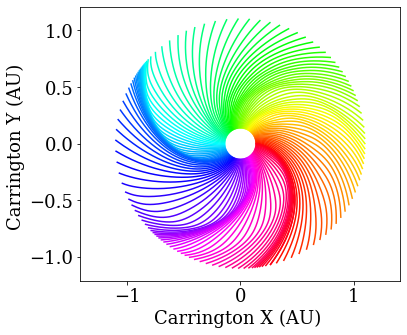

In [53]:
s_m = cmap(p)
fig, ax = plt.subplots(figsize=(6, 5))
for ii in range(len(p)):
    _ = ax.plot(np.cos(phi_shift_mhd[:, ii])*r.to(u.AU).value, 
                np.sin(phi_shift_mhd[:, ii])*r.to(u.AU).value, 
                color=s_m.to_rgba(p[ii]))

_ = ax.set_xlabel("Carrington X (AU) ")
_ = ax.set_ylabel("Carrington Y (AU) ")
_ = ax.axis("equal")


plt.tight_layout()
plt.savefig("MHD/figs/CR2210/MAS_streamlines.png")

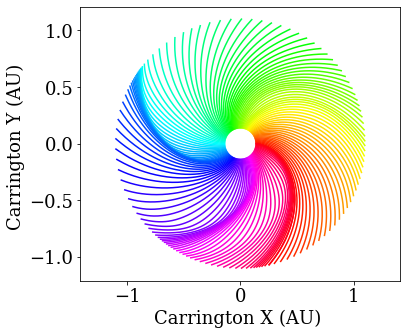

In [54]:
fig, ax = plt.subplots(figsize=(6, 5))
for ii in range(len(p)):
    _ = ax.plot(np.cos(phi_shift_hux[:, ii])*r.to(u.AU).value, 
                np.sin(phi_shift_hux[:, ii])*r.to(u.AU).value, 
                color=s_m.to_rgba(p[ii]))

_ = ax.set_xlabel("Carrington X (AU) ")
_ = ax.set_ylabel("Carrington Y (AU) ")
_ = ax.axis("equal")

plt.tight_layout()
plt.savefig("MHD/figs/CR2210/HUX_streamlines.png")

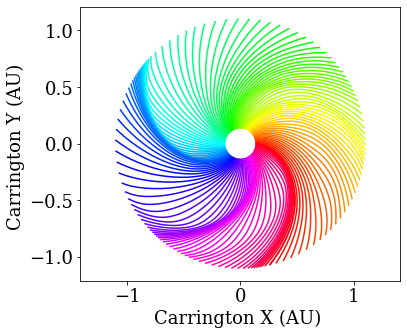

In [55]:
fig, ax = plt.subplots(figsize=(6, 5))
for ii in range(len(p)):
    _ = ax.plot(np.cos(phi_shift_sopinf[:, ii])*r.to(u.AU).value, 
                np.sin(phi_shift_sopinf[:, ii])*r.to(u.AU).value, 
                color=s_m.to_rgba(p[ii]))

_ = ax.set_xlabel("Carrington X (AU) ")
_ = ax.set_ylabel("Carrington Y (AU) ")
_ = ax.axis("equal")

plt.tight_layout()
plt.savefig("MHD/figs/CR2210/sOpInf_streamlines.png")

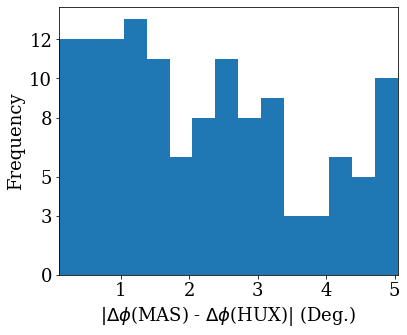

In [56]:
fig, ax = plt.subplots(figsize=(6, 5))
diff_hux = (180./np.pi)*np.abs(phi_shift_mhd[-1] - phi_shift_hux[-1])
mu, sigma = stats.norm.fit(diff_hux)
n , bins, _ = ax.hist(np.abs(diff_hux), 15)
_ = ax.set_xlim(left=0.1, right=np.max(np.abs(diff_hux)))
_ = ax.set_yticks([0,3, 5, 8, 10, 12])
_ = ax.set_ylabel("Frequency")
_ = ax.set_xlabel("$|\Delta \phi$(MAS) - $\Delta \phi$(HUX)| (Deg.)")
_ = ax.set_ylabel("Frequency") 

plt.tight_layout()
plt.savefig("MHD/figs/CR2210/HUX_vs_MAS_streamlines.png")

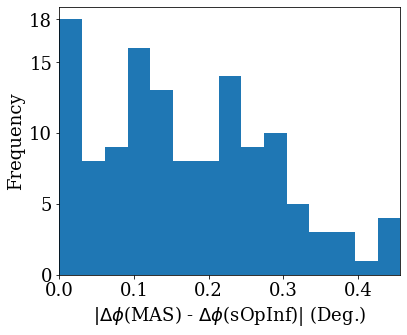

In [57]:
fig, ax = plt.subplots(figsize=(6, 5))
diff_rom = (180./np.pi)*np.abs(phi_shift_mhd[-1] - phi_shift_sopinf[-1])
mu, sigma = stats.norm.fit(diff_rom)
n , bins, _ = ax.hist(np.abs(diff_rom), 15)
_ = ax.set_xlim(left=0, right=np.max(np.abs(diff_rom)))
_ = ax.set_yticks([0, 5, 10, 15, 18])
_ = ax.set_xlabel("$|\Delta \phi$(MAS) - $\Delta \phi$(sOpInf)| (Deg.)")
_ = ax.set_ylabel("Frequency") 

plt.tight_layout()
plt.savefig("MHD/figs/CR2210/sOpInf_vs_MAS_streamlines.png")

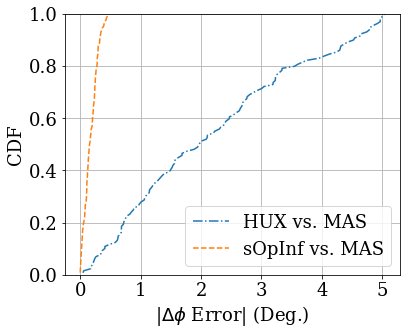

In [58]:
fig, ax = plt.subplots(figsize=(6, 5))


cdf(diff_hux, ax, label = "HUX vs. MAS", ls="-.")
cdf(diff_rom, ax, label = "sOpInf vs. MAS", ls="--")
ax.set_ylim((0,1))
ax.set_ylabel("CDF")
ax.set_xlabel("|$\Delta \phi$ Error| (Deg.)")
ax.grid(True)
_ = ax.legend()

plt.tight_layout()
plt.savefig("MHD/figs/CR2210/cdf_streamlines.png")

(HUX) mu =  2.186938867280373
(HUX) median =  1.9777172999028183
(HUX) max. =  5.047840212839434
(HUX) sigma =  1.4632554719893223
(sOpInf) mu =  0.17164642838855076
(sOpInf) sigma =  0.11482057717278871
(sOpInf) median =  0.15585729997711384
(sOpInf) max. =  0.4566031411668328


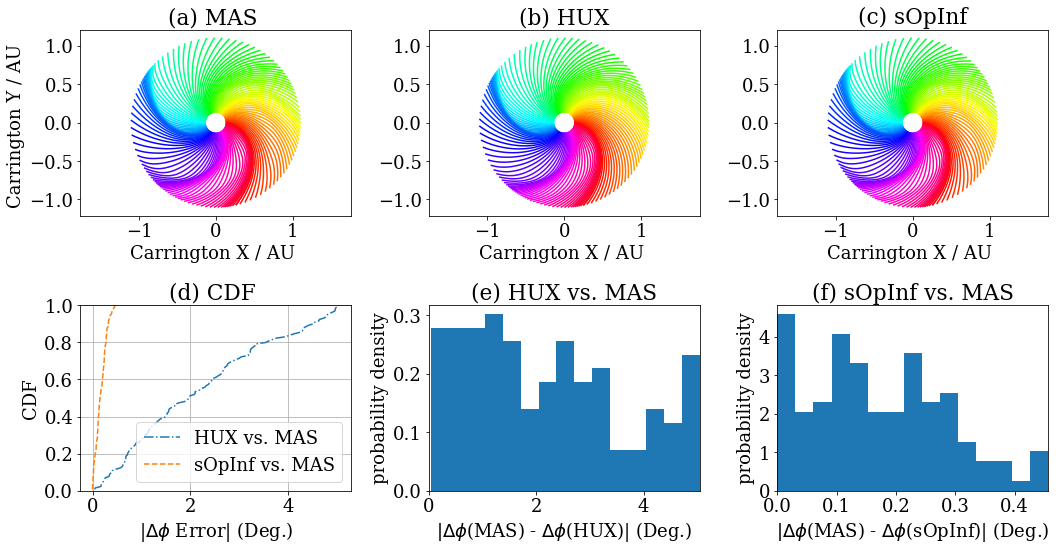

In [59]:
s_m = cmap(p)

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 8))
for ii in range(len(p)):
    _ = ax[0, 0].plot(np.cos(phi_shift_mhd[:, ii])*r.to(u.AU).value, 
                np.sin(phi_shift_mhd[:, ii])*r.to(u.AU).value, 
                color=s_m.to_rgba(p[ii]))
    _ = ax[0, 1].plot(np.cos(phi_shift_hux[:, ii])*r.to(u.AU).value, 
                np.sin(phi_shift_hux[:, ii])*r.to(u.AU).value, 
                color=s_m.to_rgba(p[ii]))
    _ = ax[0, 2].plot(np.cos(phi_shift_sopinf[:, ii])*r.to(u.AU).value, 
                np.sin(phi_shift_sopinf[:, ii])*r.to(u.AU).value, 
                color=s_m.to_rgba(p[ii]))
    
_ = ax[0, 0].set_title("(a) MAS ")
_ = ax[0, 0].set_xlabel("Carrington X / AU ")
_ = ax[0, 0].set_ylabel("Carrington Y / AU ")
_ = ax[0, 0].axis("equal")

_ = ax[0, 1].set_title("(b) HUX")
_ = ax[0, 1].set_xlabel("Carrington X / AU ")
_ = ax[0, 1].axis("equal")

_ = ax[0, 2].set_title("(c) sOpInf")
_ = ax[0, 2].set_xlabel("Carrington X / AU ")
_ = ax[0, 2].axis("equal")

diff_hux = (180./np.pi)*np.abs(phi_shift_mhd[-1] - phi_shift_hux[-1])
mu, sigma = stats.norm.fit(diff_hux)
print("(HUX) mu = ", mu )
print("(HUX) median = ", np.median(np.abs(diff_hux)))
print("(HUX) max. = ", np.max(np.abs(diff_hux)))
print("(HUX) sigma = ", sigma )
n , bins, _ = ax[1, 1].hist(np.abs(diff_hux), 15, density=1)
_ = ax[1, 1].set_xlim(left=0, right=np.max(np.abs(diff_hux)))
_ = ax[1, 1].set_title("(e) HUX vs. MAS")
_ = ax[1, 1].set_xlabel("$|\Delta \phi$(MAS) - $\Delta \phi$(HUX)| (Deg.)")
_ = ax[1, 1].set_ylabel("probability density") 



diff_rom = (180./np.pi)*np.abs(phi_shift_mhd[-1] - phi_shift_sopinf[-1])
mu, sigma = stats.norm.fit(diff_rom)
print("(sOpInf) mu = ", mu )
print("(sOpInf) sigma = ", sigma )
print("(sOpInf) median = ", np.median(np.abs(diff_rom)))
print("(sOpInf) max. = ", np.max(np.abs(diff_rom)))
n , bins, _ = ax[1, 2].hist(np.abs(diff_rom), 15, density=1)
_ = ax[1, 2].set_xlim(left=0, right=np.max(np.abs(diff_rom)))
_ = ax[1, 2].set_title("(f) sOpInf vs. MAS")
_ = ax[1, 2].set_xlabel("$|\Delta \phi$(MAS) - $\Delta \phi$(sOpInf)| (Deg.)")
_ = ax[1, 2].set_ylabel("probability density") 


cdf(diff_hux, ax[1, 0], label = "HUX vs. MAS", ls="-.")
cdf(diff_rom, ax[1, 0], label = "sOpInf vs. MAS", ls="--")
ax[1, 0].set_ylim((0,1))
ax[1, 0].set_ylabel("CDF")
ax[1, 0].set_xlabel("|$\Delta \phi$ Error| (Deg.)")
ax[1, 0].grid(True)
ax[1, 0].set_title("(d) CDF ")
_ = ax[1, 0].legend()

plt.tight_layout()
plt.savefig("MHD/figs/CR" + str(cr) + "/H/MAS_HUX_sOpInf_H_streamlines.png")

### Can we improve prediction by regularization? to avoid overfitting to the training dataset. Find the optimal regularization coefficient $\lambda_{1}$.

In [60]:
coeff_array = 10**np.arange(0, 10)

training_error = np.ones((len(coeff_array))) * np.inf
testing_error = np.ones((len(coeff_array))) * np.inf

for kk, coeff in enumerate(coeff_array):
    Vr, _ = roi.pre.pod_basis(X_train, r=9) 
    Xdot = roi.pre.xdot_nonuniform(X_train, r_train.value) 
    model = roi.InferredContinuousROM(modelform="H")            
    model.fit(Vr, X_train, Xdot, P=coeff)                          
    X_ROM = model.predict(X[:, 0], r.value, method="BDF") 

    if np.shape(X_ROM) == np.shape(V):
        V_ROM = convert_from_x_to_v(X_ROM, p, r, m, b, shift_function)
        # save
        training_error[kk] = np.max(np.abs((V[:, :l] - V_ROM[:, :l])/V[:, :l]))
        # save
        testing_error[kk] = np.max(np.abs((V[:, l:] - V_ROM[:, l:])/V[:, l:]))

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


In [61]:
idx  = np.unravel_index(training_error.argmin(), training_error.shape)
print("Training lambda =",  np.log10(coeff_array[idx[0]]))

Training lambda = 5.0


In [62]:
idx  = np.unravel_index(testing_error.argmin(), testing_error.shape)
print("Testing lambda =",  np.log10(coeff_array[idx[0]]))

Testing lambda = 5.0


# Sensitivity to Training Data

In [63]:
# initialize the training length. 
l1, l2, l3 = int(0.5*len(r)), int(0.6*len(r)), int(0.7*len(r))


X_train1 = X[:, :l1]
X_test1 = X[:, l1:-1]


X_train2 = X[:, :l2]
X_test2 = X[:, l2:-1]


X_train3 = X[:, :l3]
X_test3 = X[:, l3:-1]

In [64]:
r_train1 = r[:l1]
r_test1 = r[l1:-1]

r_train2 = r[:l2]
r_test2 = r[l2:-1]

r_train3 = r[:l3]
r_test3 = r[l3:-1]

In [65]:
# l1 = compute the results for quadradic with 3 modes.
rank=9
Vr, _ = roi.pre.pod_basis(X_train1, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot_nonuniform(X_train1, r_train1.value)  # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train1, Xdot, P=1e5)                          # Construct the ROM with Operator Inference.
X_ROM1 = model.predict(X[:, 0], r.value, method="BDF") # Simulate the ROM.
V_ROM1 = convert_from_x_to_v(X_ROM1, p, r, m, b, shift_function)

# l2 = compute the results for quadradic with 3 modes.
Vr, _ = roi.pre.pod_basis(X_train2, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot_nonuniform(X_train2, r_train2.value)  # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train2, Xdot, P=1e5)                          # Construct the ROM with Operator Inference.
X_ROM2 = model.predict(X[:, 0], r.value, method="BDF") # Simulate the ROM.
V_ROM2 = convert_from_x_to_v(X_ROM2, p, r, m, b, shift_function)

# l3 = compute the results for quadradic with 3 modes.
Vr, _ = roi.pre.pod_basis(X_train3, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot_nonuniform(X_train3, r_train3.value) # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train3, Xdot, P=1e5)                          # Construct the ROM with Operator Inference.
X_ROM3 = model.predict(X[:, 0], r.value, method="BDF") # Simulate the ROM.
V_ROM3 = convert_from_x_to_v(X_ROM3, p, r, m, b, shift_function)

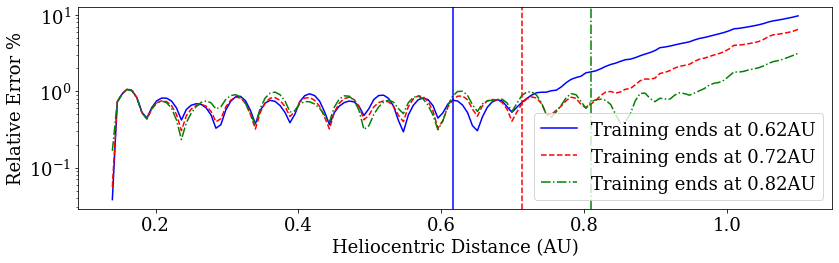

In [66]:
fig, ax = plt.subplots(figsize=(12, 4))
# l1
abs_l2err1, rel_l2err1 = roi.post.lp_error(V, V_ROM1, 2)
_ = ax.plot(r.to(u.AU).value, 100*rel_l2err1, "-", c="b", label="Training ends at " + str(round(r[l1].to(u.AU).value, 2)) + "AU")

#l2
abs_l2err2, rel_l2err2 = roi.post.lp_error(V, V_ROM2, 2)
_ = ax.plot(r.to(u.AU).value, 100*rel_l2err2, "--", c="r", label="Training ends at " + str(round(r[l2].to(u.AU).value, 2)) + "AU")

#l3
abs_l2err3, rel_l2err3 = roi.post.lp_error(V, V_ROM3, 2)
_ = ax.plot(r.to(u.AU).value, 100*rel_l2err3, "-.", c="g", label="Training ends at " + str(round(r[l3].to(u.AU).value, 2)) + "AU")

_ = ax.axvline(r_train1[-1].to(u.AU).value, linestyle="-", c="b")
_ = ax.axvline(r_train2[-1].to(u.AU).value, linestyle="--", c="r")
_ = ax.axvline(r_train3[-1].to(u.AU).value, linestyle="-.", c="g")
_ = ax.set_ylabel("Relative Error %")
_ = ax.set_xlabel("Heliocentric Distance (AU)")
_ = ax.set_yscale("log")
plt.legend()
plt.tight_layout()

plt.savefig("MHD/figs/CR2210/H/sensitivity_to_number_of_training_snapshots.png", dpi=300)